# Creating and using `PSpecBeam` objects
`PSpecBeam` objects carry information about the primary beam, such as how the beam solid angle varies with frequency. This information is needed to rescale power spectra into cosmological units, through the computation of a 'beam scalar'.

There are several different ways to construct a `PSpecBeam` object.

## Gaussian beams: `PSpecBeamGauss`
A Gaussian beam type is provided for simple testing purposes. We will use this to demonstrate the basic usage of `PSpecBeam` objects.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import hera_pspec as hp

In [2]:
# Each beam is defined over a frequency interval:
beam_freqs = np.linspace(100e6, 200e6, 200) # in Hz

# Create a new Gaussian beam object with full-width at half-max. of 0.1 radians
beam_gauss = hp.PSpecBeamGauss(fwhm=0.1, beam_freqs=beam_freqs)

We now have a `PSpecBeamGauss` object, with a constant FWHM of 0.1 radians, defined over a frequency interval of [100, 200] MHz.

`PSpecBeam` objects have a cosmology attached to them. Because we didn't manually specify a cosmology, this object was automatically instantiated with the default cosmology from `hera_pspec.conversions`:

In [3]:
print(beam_gauss.cosmo)

Cosmo_Conversions object at <0x7f887bf7d828>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


### Calculating the scalar conversion factor

There are two main `PSpecBeam` methods that are needed by other bits of `hera_pspec`. The first is `compute_pspec_scalar()`, which outputs the scalar conversion factor for a specified range of frequencies. This factor is used to convert power spectra into physical units, e.g. in `PSpecData.pspec()`. It is calculated by performing two integrals, over the beam solid angle and the beam solid angle squared, and multiplying their ratio by a cosmological distance factor.

The `compute_pspec_scalar()` method takes several arguments: to specify the frequency range to integrate the scalar over (`lower_freq`, `upper_freq`, and `num_freqs`); to specify which polarization to calculate the scalar for (`pol`), and to specify whether a tapering function has been applied to the power spectrum (`taper`):

In [4]:
scalar = beam_gauss.compute_pspec_scalar(lower_freq=100e6, upper_freq=120e6, num_freqs=20, 
                                         num_steps=5000, pol='XX', taper='none', 
                                         little_h=True)
print("Scalar:", scalar)

Scalar: 280222020.67454016


In `PSpecData`, the delay spectrum returned by `p_hat` (calculated by applying an optimal quadratic estimator to a pair of visbilities) is multiplied by `scalar` to convert it to cosmological units.

In the above, the frequency range should correspond to the frequency range that the delay spectrum was calculated over. The `num_freqs` argument sets the size of the grid to evaluate the scalar integrand over, and is usually chosen to be a reasonably small value, since the integrand tends to vary quite smoothly with frequency.

### Beam solid angle integrals
The `num_steps` argument, on the other hand, specifies the size of the grid over which the beam solid angle should be interpolated before it is integrated (i.e. to produce the scalar integrand). This should normally be set to a larger value, as accuracy is more important here. The integrals of the beam solid angle are returned by the following methods (which return arrays of the same size as `beam_freqs`):

Text(0.5, 0, 'Freq. [MHz]')

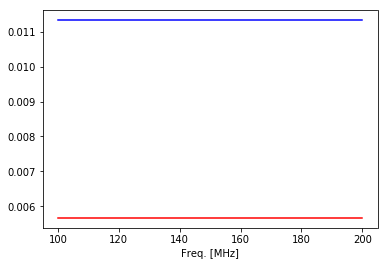

In [5]:
OmegaP = beam_gauss.power_beam_int()
OmegaPP = beam_gauss.power_beam_sq_int()

plt.plot(beam_freqs/1e6, OmegaP, 'b-')
plt.plot(beam_freqs/1e6, OmegaPP, 'r-')
plt.xlabel("Freq. [MHz]")

The integrals of the beam solid angle are trivial in this example, as we are using a Gaussian beam with a FWHM that is constant in frequency.

### Units and normalization

The `compute_pspec_scalar()` has several other keyword arguments. In the example above, `little_h=True` was specified, to return the scalar in units that will result in a power spectrum that is in $(h^{-1} {\rm Mpc})^3$ units.

The normalization of the power spectrum also depends on whether a taper was applied to the data. The taper that was used can be specified as a string, using the `taper` keyword argument (which we set to `none` here).

### Noise power spectrum normalization
Noise power spectra need a different normalization scalar to signal power spectra. To calculate the scalar for a noise power spectrum, pass `noise_scalar=True` to `compute_pspec_scalar()`.

### Conversion to temperature units
A beam solid angle is also needed to convert between flux density units and temperature units. The `Jy_to_mK()` method performs this conversion. To calculate this factor, pass a frequency and polarization:

In [6]:
freqs = np.linspace(100e6, 200e6, 5) # in Hz
print(beam_gauss.Jy_to_mK(freqs, pol='XX'))

[287.25252717 183.84161739 127.66778985  93.79674357  71.81313179]


Assuming that you have visibilities that are known to be in Jy units, you can apply this conversion to a `pyuvdata.UVData` object like so:

In [7]:
from pyuvdata import UVData
import os

# Create a UVData object and fill it with data
datafile = os.path.join('../hera_pspec/data/', 'zen.2458042.12552.xx.HH.uvXAA')
uvd = UVData()
uvd.read_miriad(datafile)

# Apply unit conversion factor to UVData
uvd.data_array *= beam_gauss.Jy_to_mK(np.unique(uvd.freq_array))[None, None, :, None]
# The expression [None, None, :, None] reshapes the conversion factor into the same shape as as the data_array

Any power spectra created using this `UVData` object will be ${\rm mK}$ units (actually, ${\rm mK}^2 ({\rm Mpc})^3$ or similar).

## Passing a beam to `PSpecData`
The main purpose of `PSpecBeam` objects is to provide the `PSpecData` class with a way of normalizing the power spectra that it produces. To attach a `PSpecBeam` object to a `PSpecData` object, you can either pass one in when you instantiate the class, i.e.

In [8]:
# Create PSpecData with a beam attached
psd = hp.PSpecData(dsets=[], wgts=[], beam=beam_gauss)

Or, you can specify a beam manually, i.e.

In [9]:
psd.primary_beam = beam_gauss

The `PSpecData.scalar()` method will then use the correct beam to rescale the power spectra output by `PSpecData.pspec()`.

Note that if you do not specify a beam file at any point, `PSpecData.scalar()` will raise the following warning when it is called: "Warning: self.primary_beam is not defined, so pspectra are not properly normalized". It will then set `scalar = 1` and continue running.

## Beams from a `UVBeam` object: `PSpecBeamUV`
Real beams are considerably more complicated than the Gaussian example. The `hera_pspec` module currently supports beams that are specified in the `UVBeam` format provided by the `pyuvdata` package. These usually contain Healpix-pixelated beams as a function of frequency and polarization.

To create a beam that uses this format, simply create a new `PSpecBeamUV` instance with the name of a `beamfits` file that is supported by `UVBeam`:

In [10]:
beamfile = os.path.join('../hera_pspec/data/', 'HERA_NF_dipole_power.beamfits')
beam_uv = hp.PSpecBeamUV(beamfile)

Internally, `PSpecBeam` will calculate the beam solid angle integrals using the `UVBeam.get_beam_area()` and `UVBeam.get_beam_sq_area()` methods. These use Healpix to perform the integrals using spherical harmonic transforms. The relevant frequency ranges will be read directly from the `UVBeam` object. Other than this detail, `PSpecBeamUV` objects behave in the same way as `PSpecBeamGauss` object, e.g. to calculate the beam scalar:

In [11]:
scalar = beam_uv.compute_pspec_scalar(lower_freq=100e6, upper_freq=120e6, num_freqs=20, 
                                      num_steps=5000, pol='XX', taper='none', 
                                      little_h=True)
print("Scalar:", scalar)

Scalar: 2035226379.7771878


To access the `UVBeam` object stored inside a `PSpecBeamUV`, you can do the following:

In [12]:
uvbeam = beam_uv.primary_beam
print(uvbeam)

## Beam from beam solid angle arrays: `PSpecBeamFromArray`
If you want to experiment with non-trivial primary beam models without having to construct `UVBeam` objects and all of the metadata that they require, use `PSpecBeamFromArray`. This allows you to provide the integrated beam and beam-squared solid angles (i.e. the outputs of the `power_beam_int()` and `power_beam_sq_int()` methods) manually, as a set of arrays as a function of frequency.

You can either pass in arrays for a single polarization (which will be assumed to be `XX`), or you can pass in dictionaries with arrays for multiple polarizations.

In [13]:
# Add the integrated beam arrays that we output for the Gaussian beam earlier
# if fed arrays assumes pI polarization
custom_beam = hp.PSpecBeamFromArray(OmegaP=OmegaP, OmegaPP=OmegaPP, beam_freqs=beam_freqs)

# Use the same beam arrays, but to specify multiple polarizations using dicts
custom_beam2 = hp.PSpecBeamFromArray(OmegaP={'XX': OmegaP, 'YY': OmegaP}, 
                                     OmegaPP={'XX': OmegaPP, 'YY': OmegaPP},
                                     beam_freqs=beam_freqs)

You can also add additional polarizations (or replace existing ones) using the `add_pol()` method:

In [14]:
custom_beam.add_pol(pol='XY', OmegaP=OmegaP, OmegaPP=OmegaPP)

You can check which polarizations are available in a couple of ways:

In [15]:
print("Method 1:", custom_beam.OmegaP.keys())
print("Method 2:", custom_beam)

Method 1: dict_keys([1, -7])
Method 2: PSpecBeamFromArray object
	Frequency range: Min. 1.0000e+08 Hz, Max. 2.0000e+08 Hz
	Available pols: pI, xy


## Creating your own `PSpecBeam` class
In case you have beam information in a custom format and want to create your own `PSpecBeam` class, subclass off `PSpecBeamBase`. This provides the `compute_pspec_scalar()` and `Jy_to_mK()` methods, and your subclass should provide `power_beam_int(pol)` and `power_beam_sq_int(pol)` methods.

It should also set the `self.beam_freqs` and `self.cosmo` properties, as these are expected by the `PSpecBeamBase` methods.